In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import subprocess

REPO_DIR = Path('/content/WAM')

if not REPO_DIR.exists():
    subprocess.check_call(["git", "clone", "https://github.com/facebookresearch/watermark-anything.git", str(REPO_DIR)])
else:
    subprocess.check_call(["git", "-C", str(REPO_DIR), "pull"])

print("REPO_DIR:", REPO_DIR)

REPO_DIR: /content/WAM


In [ ]:
from pathlib import Path

WATSON_DIR = Path('/content/drive/MyDrive/WATSON')
INPUT_PDF_DIR = WATSON_DIR / 'test_pdfs'
OUTPUT_DIR = WATSON_DIR / 'wam_outputs'
IMG_DIR = OUTPUT_DIR / 'pages'
WM_DIR = OUTPUT_DIR / 'watermarked'

for p in [INPUT_PDF_DIR, OUTPUT_DIR, IMG_DIR, WM_DIR]:
    p.mkdir(parents=True, exist_ok=True)

WAM_DIR = Path('/content/WAM')  # 클론 위치와 동일

assert WAM_DIR.exists(), f"WAM 폴더가 없습니다: {WAM_DIR}"

print("WAM_DIR:", WAM_DIR)
print("INPUT_PDF_DIR:", INPUT_PDF_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

WAM_DIR: /content/WAM
INPUT_PDF_DIR: /content/drive/MyDrive/WATSON/test_pdfs
OUTPUT_DIR: /content/drive/MyDrive/WATSON/wam_outputs


In [ ]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r",
str(WAM_DIR / "requirements.txt")])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
"pymupdf"])

0

In [ ]:
import urllib.request

ckpt_dir = WAM_DIR / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)

ckpt_path = ckpt_dir / "wam_mit.pth"
if not ckpt_path.exists():
    url = "https://dl.fbaipublicfiles.com/watermark_anything/wam_mit.pth"
    urllib.request.urlretrieve(url, ckpt_path)

print("MIT weights:", ckpt_path)

MIT weights: /content/WAM/checkpoints/wam_mit.pth


In [ ]:
import fitz

DPI = 300
def pdf_to_images(pdf_path, out_dir, dpi=DPI):
    doc = fitz.open(pdf_path)
    out_paths = []
    for i, page in enumerate(doc):
        pix = page.get_pixmap(dpi=dpi)
        out_path = out_dir / f"{pdf_path.stem}_p{i+1:03d}.png"
        pix.save(out_path)
        out_paths.append(out_path)
    doc.close()
    return out_paths

pdf_files = sorted(INPUT_PDF_DIR.glob("*.pdf"))
all_images = []

for pdf in pdf_files:
    all_images += pdf_to_images(pdf, IMG_DIR)

print("PDF 개수:", len(pdf_files))
print("변환된 이미지 수:", len(all_images))

PDF 개수: 1
변환된 이미지 수: 9


In [ ]:
import os, sys, torch
import torch.nn.functional as F
from PIL import Image
from torchvision.utils import save_image

sys.path.append(str(WAM_DIR))
os.chdir(WAM_DIR)

from notebooks.inference_utils import (
    load_model_from_checkpoint,
    default_transform,
    create_random_mask,
    unnormalize_img,
    msg2str
)
from watermark_anything.data.metrics import msg_predict_inference

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

json_path = WAM_DIR / "checkpoints" / "params.json"
ckpt_path = WAM_DIR / "checkpoints" / "wam_mit.pth"

wam = load_model_from_checkpoint(str(json_path),
str(ckpt_path)).to(device).eval()

making attention of type 'vanilla' with 64 in_channels
Working with z of shape (1, 68, 32, 32) = 69632 dimensions.
making attention of type 'vanilla' with 64 in_channels
Model loaded successfully from /content/WAM/checkpoints/wam_mit.pth
{'embedder_config': 'configs/embedder.yaml', 'augmentation_config': 'configs/all_augs_multi_wm.yaml', 'extractor_config': 'configs/extractor.yaml', 'attenuation_config': 'configs/attenuation.yaml', 'embedder_model': 'vae_small', 'extractor_model': 'sam_base', 'nbits': 32, 'img_size': 256, 'img_size_extractor': 256, 'attenuation': 'jnd_1_3_blue', 'scaling_w': 2.0, 'scaling_w_schedule': None, 'scaling_i': 1.0, 'roll_probability': 0.2, 'multiple_w': 1.0, 'nb_wm_eval': 5, 'optimizer': 'AdamW,lr=1e-4', 'optimizer_d': None, 'scheduler': 'CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', 'epochs': 200, 'batch_size': 8, 'batch_size_eval': 16, 'temperature': 1.0, 'workers': 8, 'to_freeze_embedder': None, 'lambda_w': 1.0, 'lambda_w2': 

In [ ]:

from tqdm import tqdm

def load_img(path):
    img = Image.open(path).convert("RGB")
    img = default_transform(img).unsqueeze(0).to(device)
    return img

if not all_images:
    raise RuntimeError("변환된 이미지가 없습니다. INPUT_PDF_DIR에 PDF를 넣었는지 확인하세요.")

mask_pct = 0.15  # 워터마크 적용 비율 (0~1)
wm_msg = wam.get_random_msg(1)  # 32-bit 메시지
print("message:", msg2str(wm_msg[0]))

results = []
for img_path in tqdm(all_images):
    img_pt = load_img(img_path)
    outputs = wam.embed(img_pt, wm_msg)

    mask = create_random_mask(img_pt, num_masks=1, mask_percentage=mask_pct)
    img_w = outputs["imgs_w"] * mask + img_pt * (1 - mask)

    preds = wam.detect(img_w)["preds"]
    mask_preds = torch.sigmoid(preds[:, 0, :, :])
    bit_preds = preds[:, 1:, :, :]

    pred_message = msg_predict_inference(bit_preds, mask_preds).cpu().float()
    bit_acc = (pred_message == wm_msg).float().mean().item()

    mask_preds_res = F.interpolate(
        mask_preds.unsqueeze(1),
        size=(img_pt.shape[-2], img_pt.shape[-1]),
        mode="bilinear",
        align_corners=False
    )

    out_base = WM_DIR / img_path.stem
    save_image(unnormalize_img(img_w), f"{out_base}_wm.png")
    save_image(mask_preds_res, f"{out_base}_predmask.png")
    save_image(mask, f"{out_base}_targetmask.png")

    results.append((img_path.name, bit_acc))

print("샘플 결과:", results[:5])

message: 10011010001101101010010000101010


100%|██████████| 9/9 [00:17<00:00,  1.98s/it]

샘플 결과: [('test1_pdf_p001.png', 1.0), ('test1_pdf_p002.png', 1.0), ('test1_pdf_p003.png', 1.0), ('test1_pdf_p004.png', 1.0), ('test1_pdf_p005.png', 1.0)]


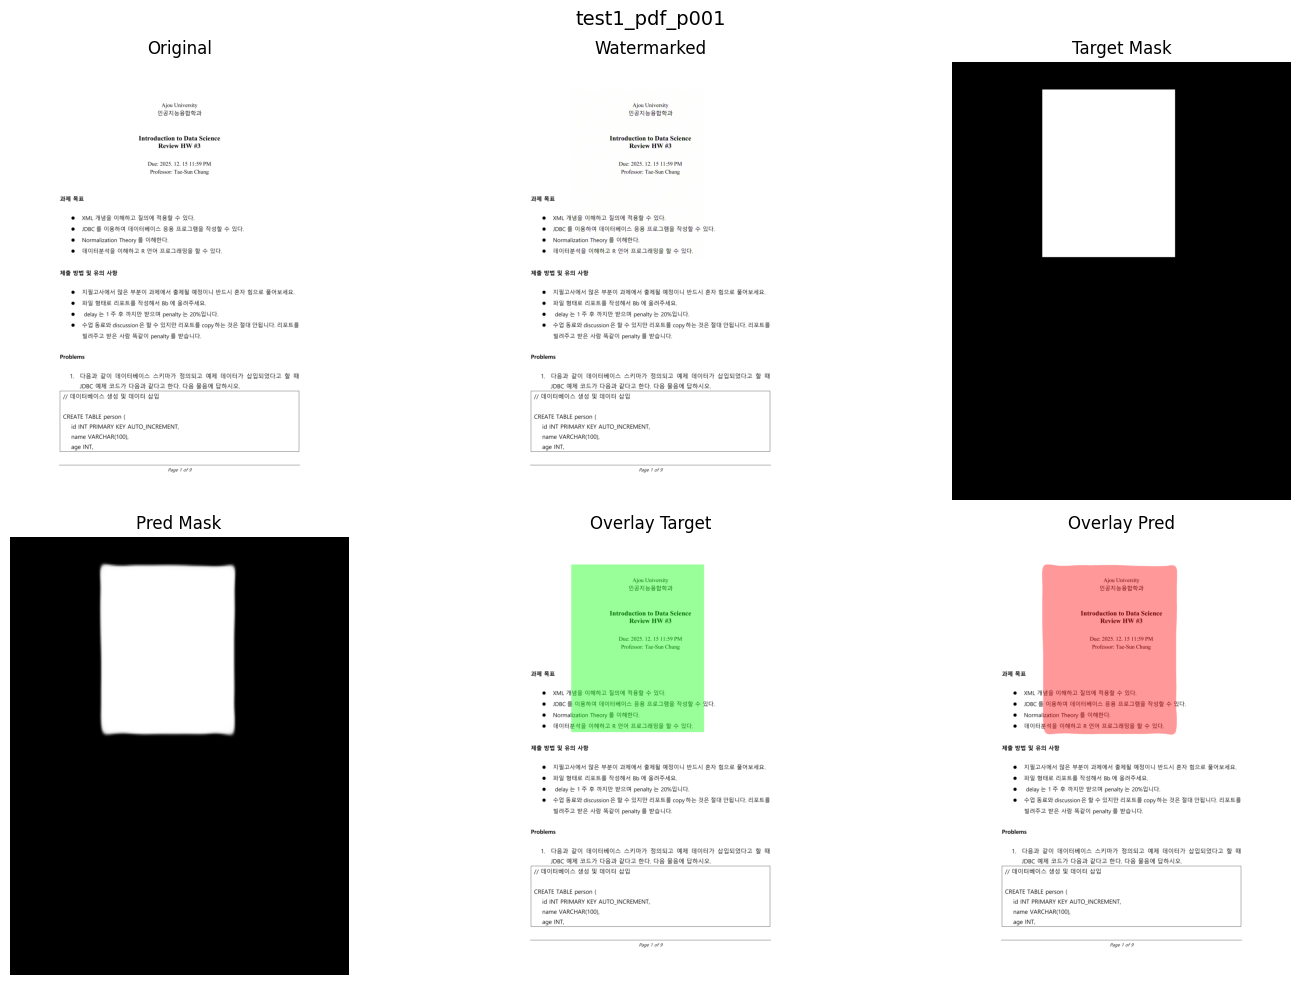

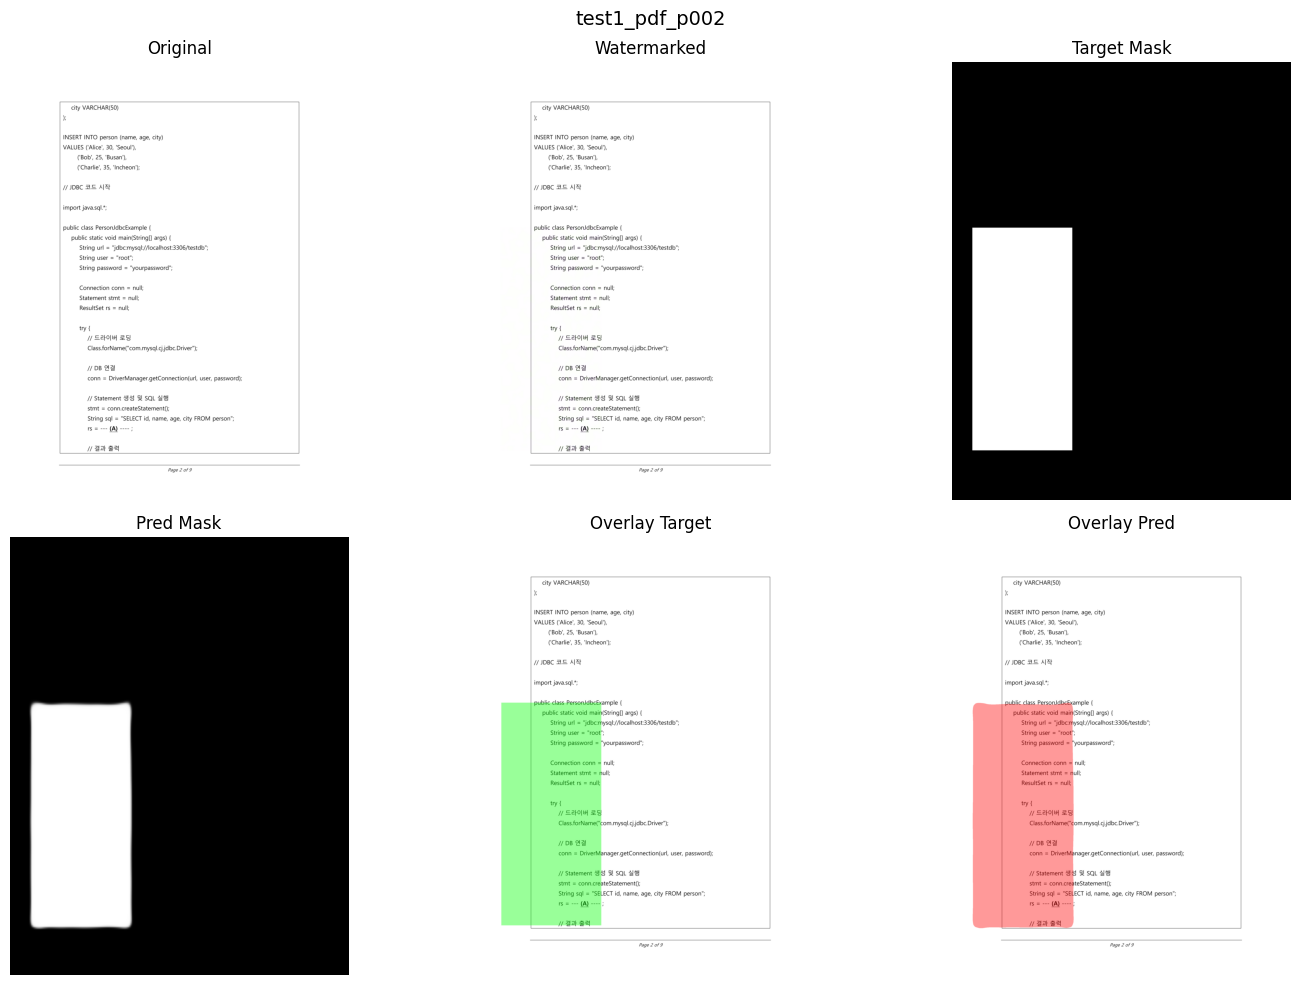

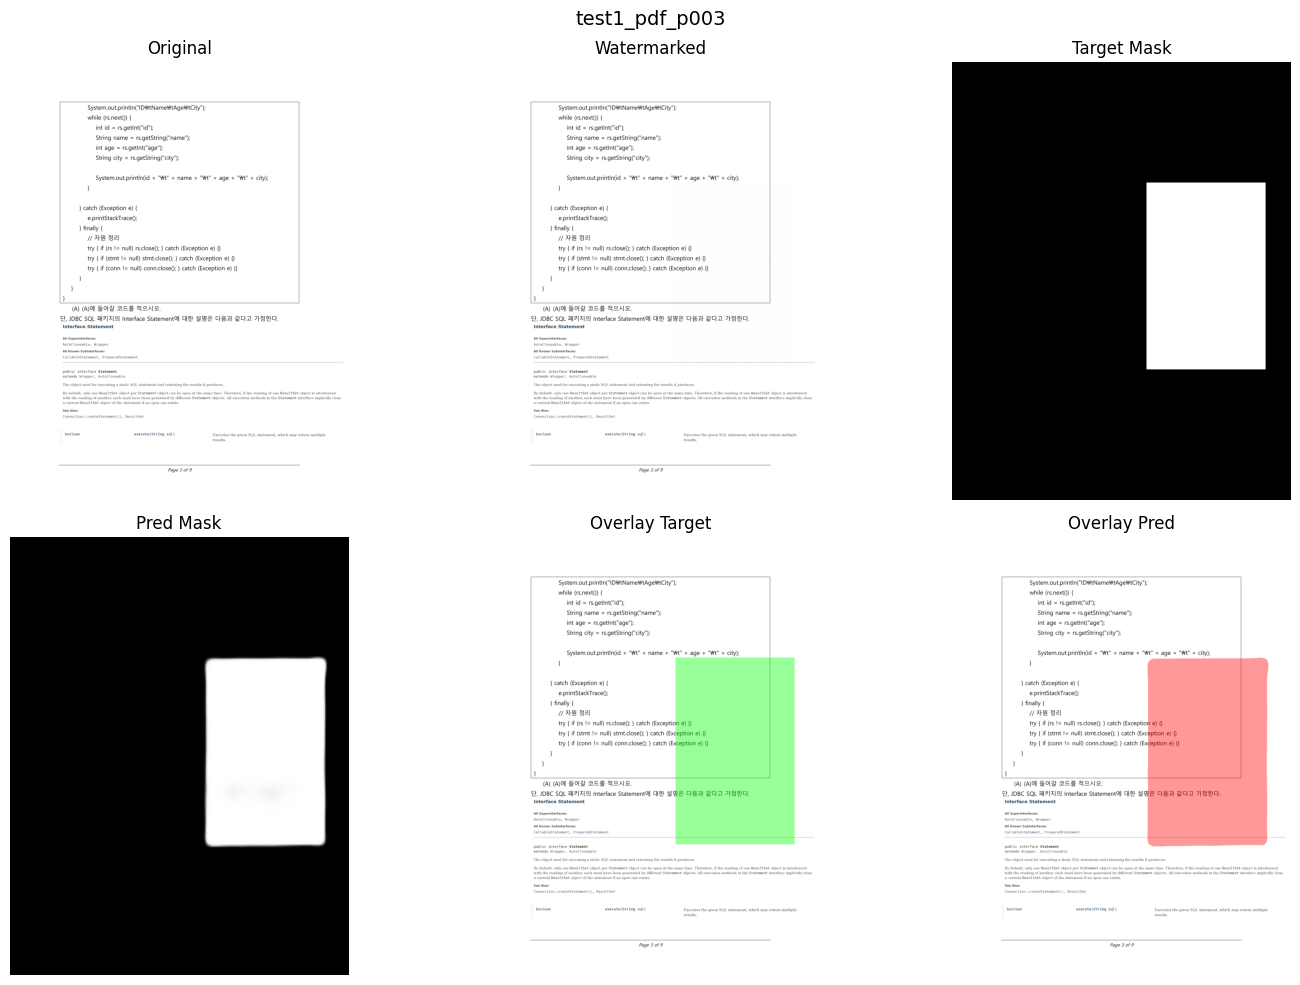

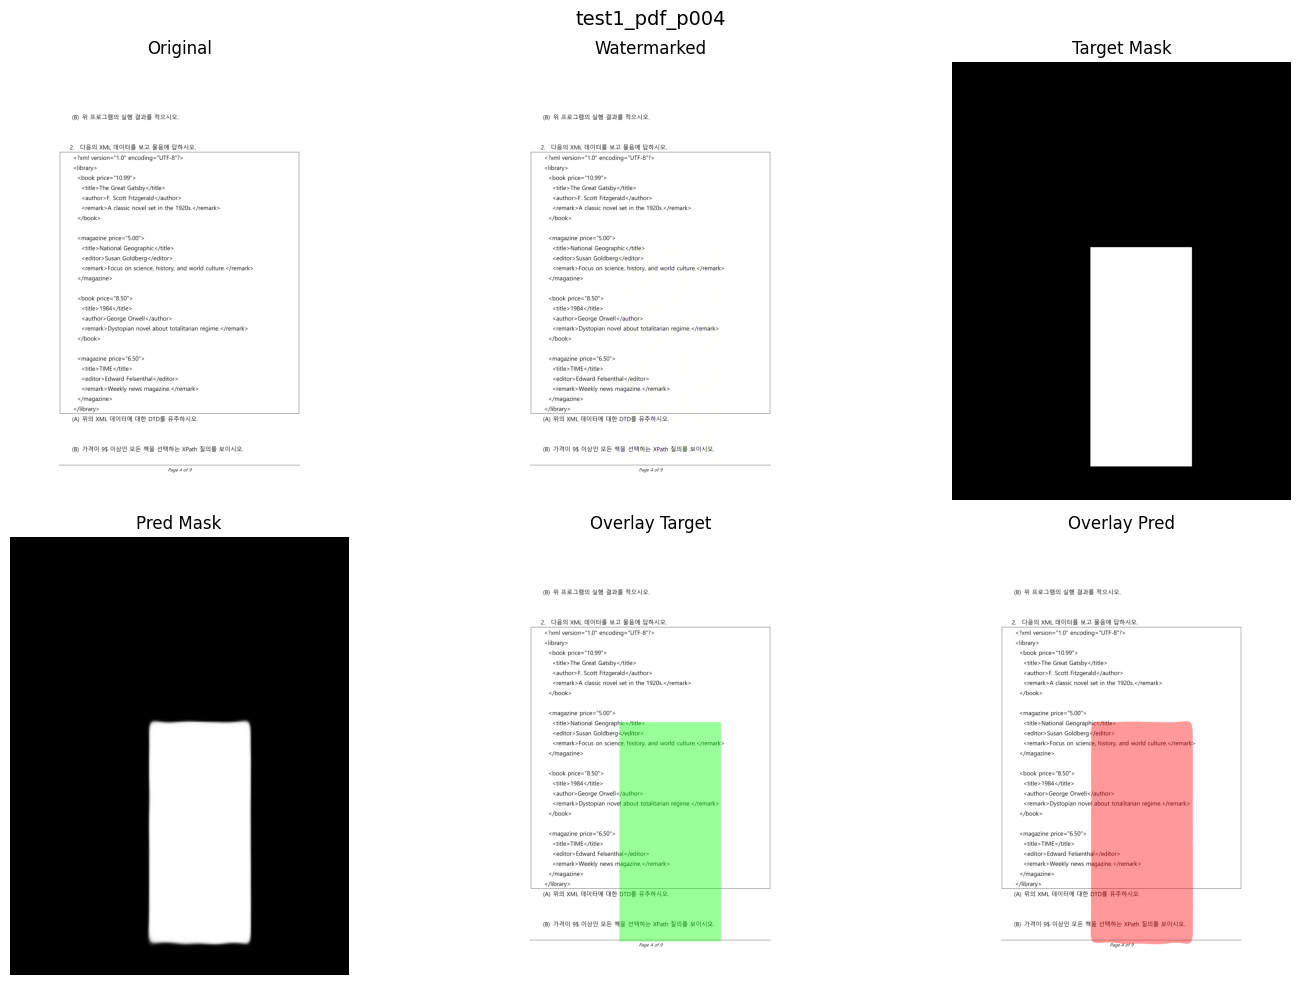

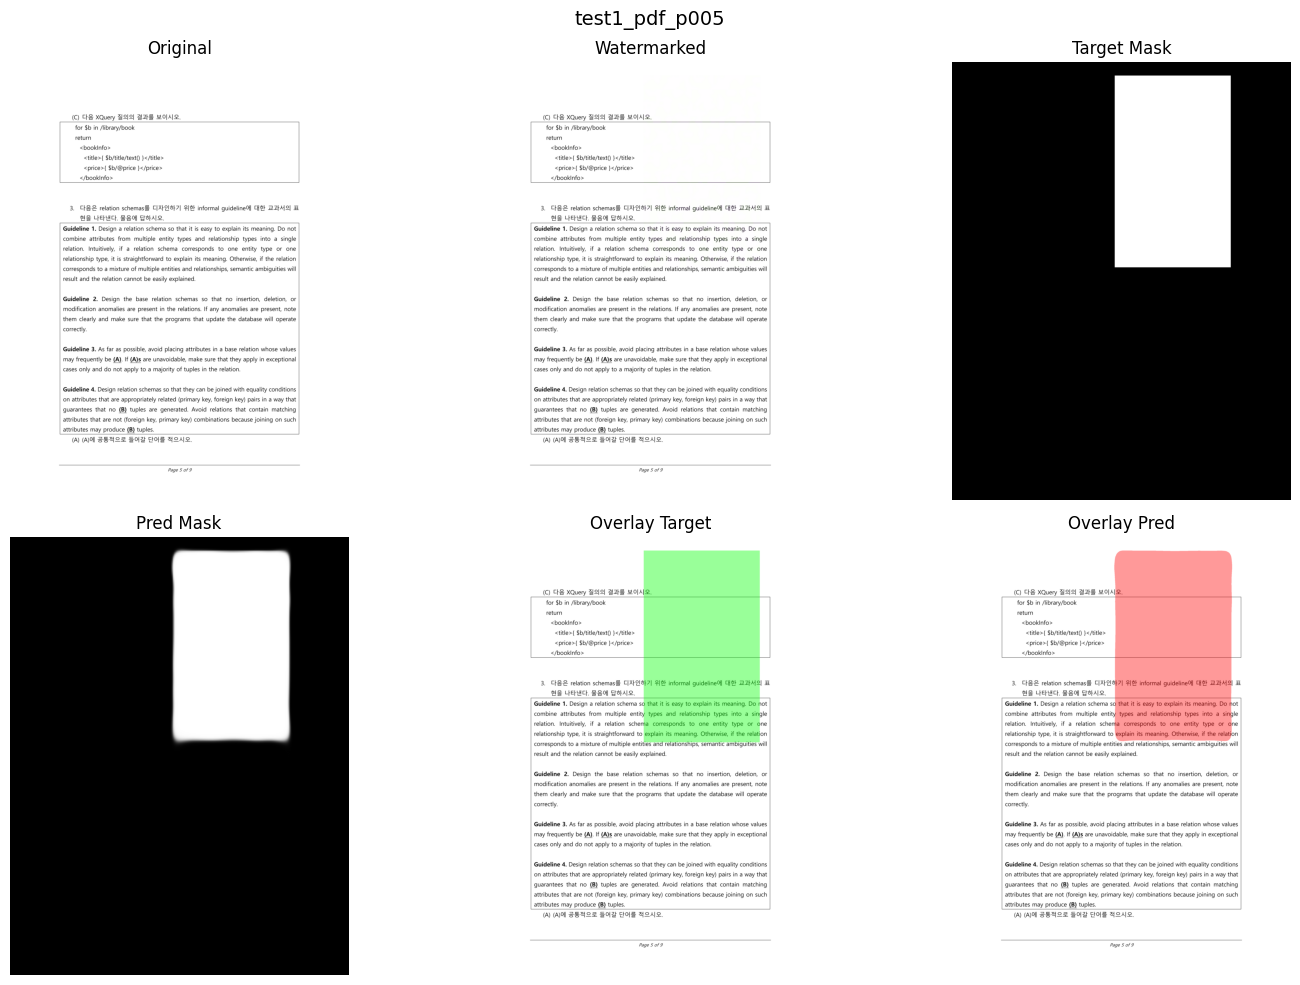

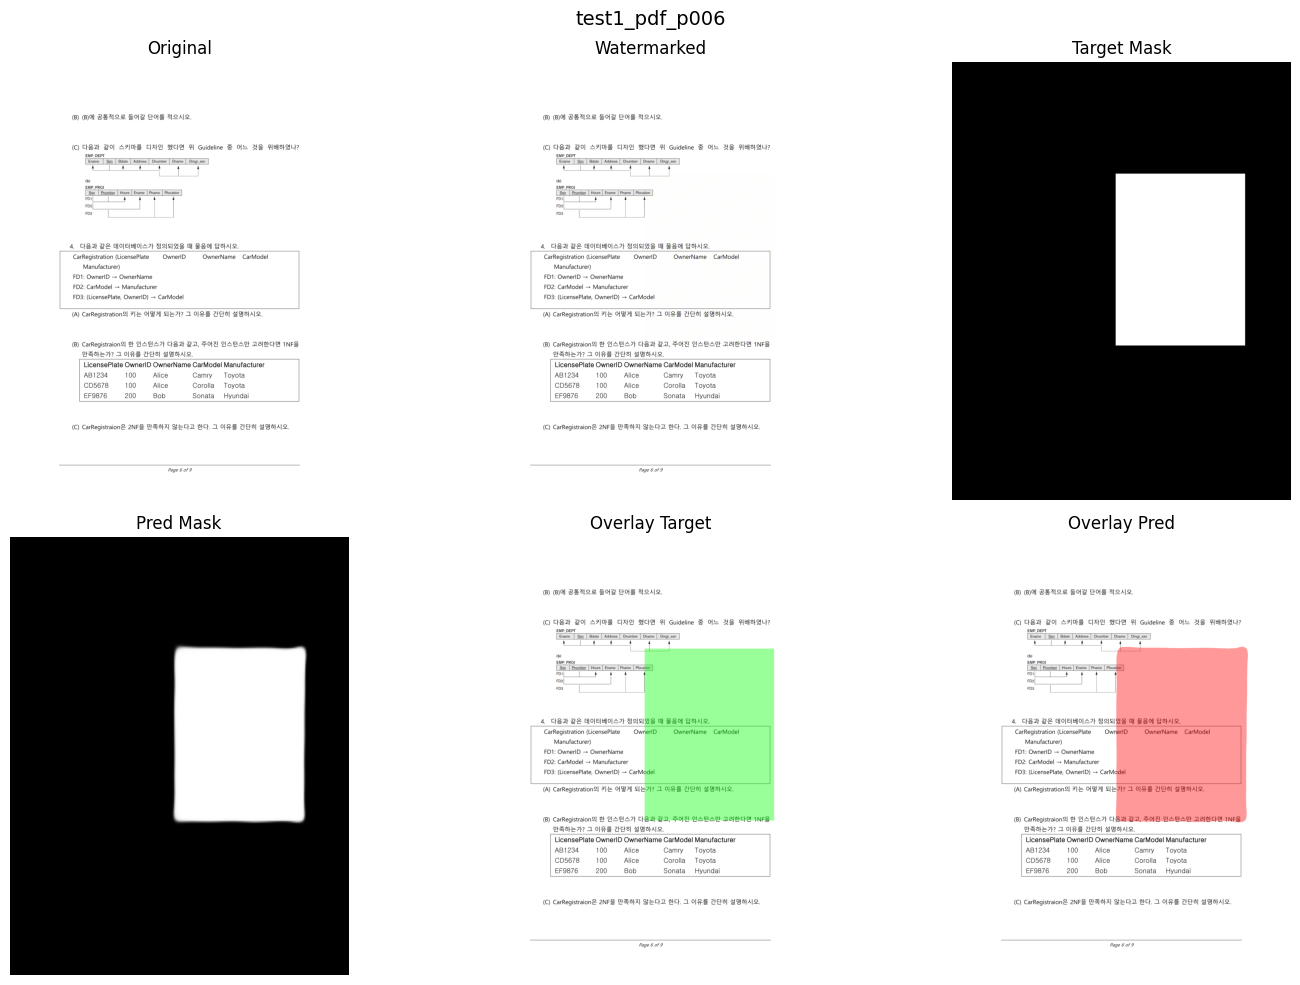

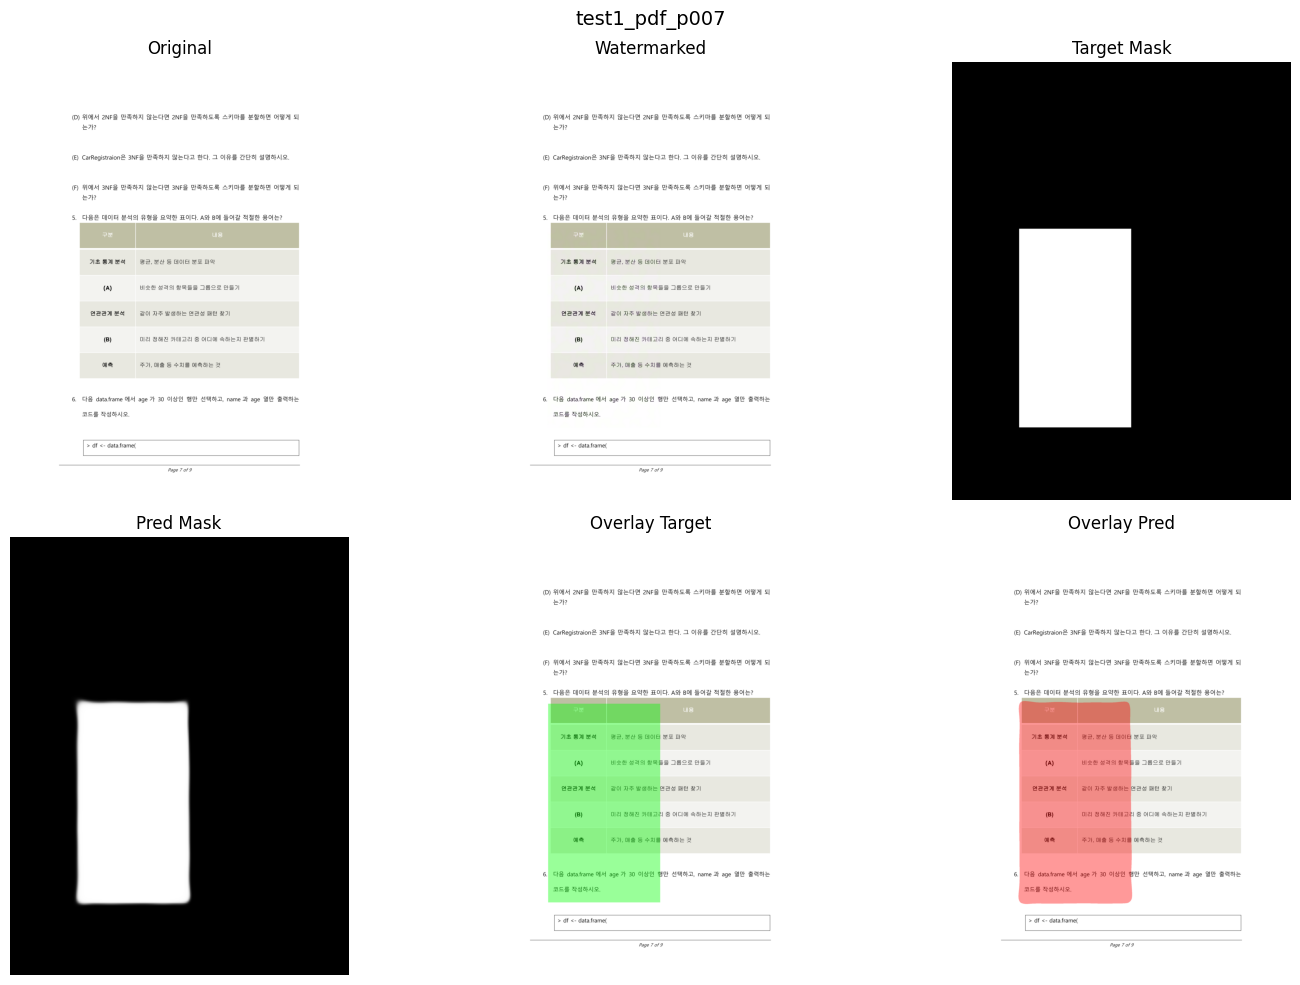

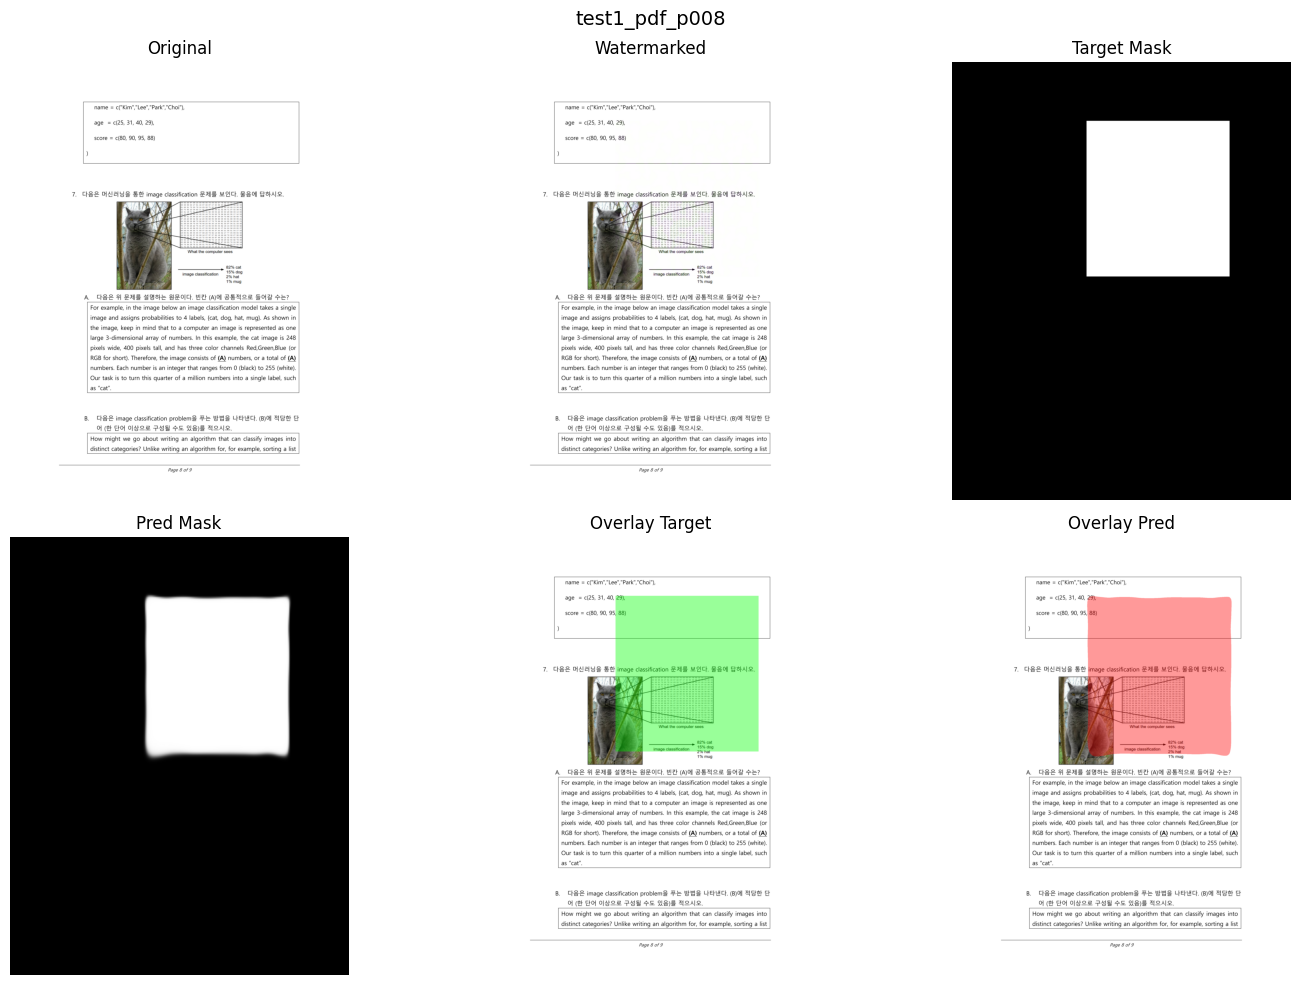

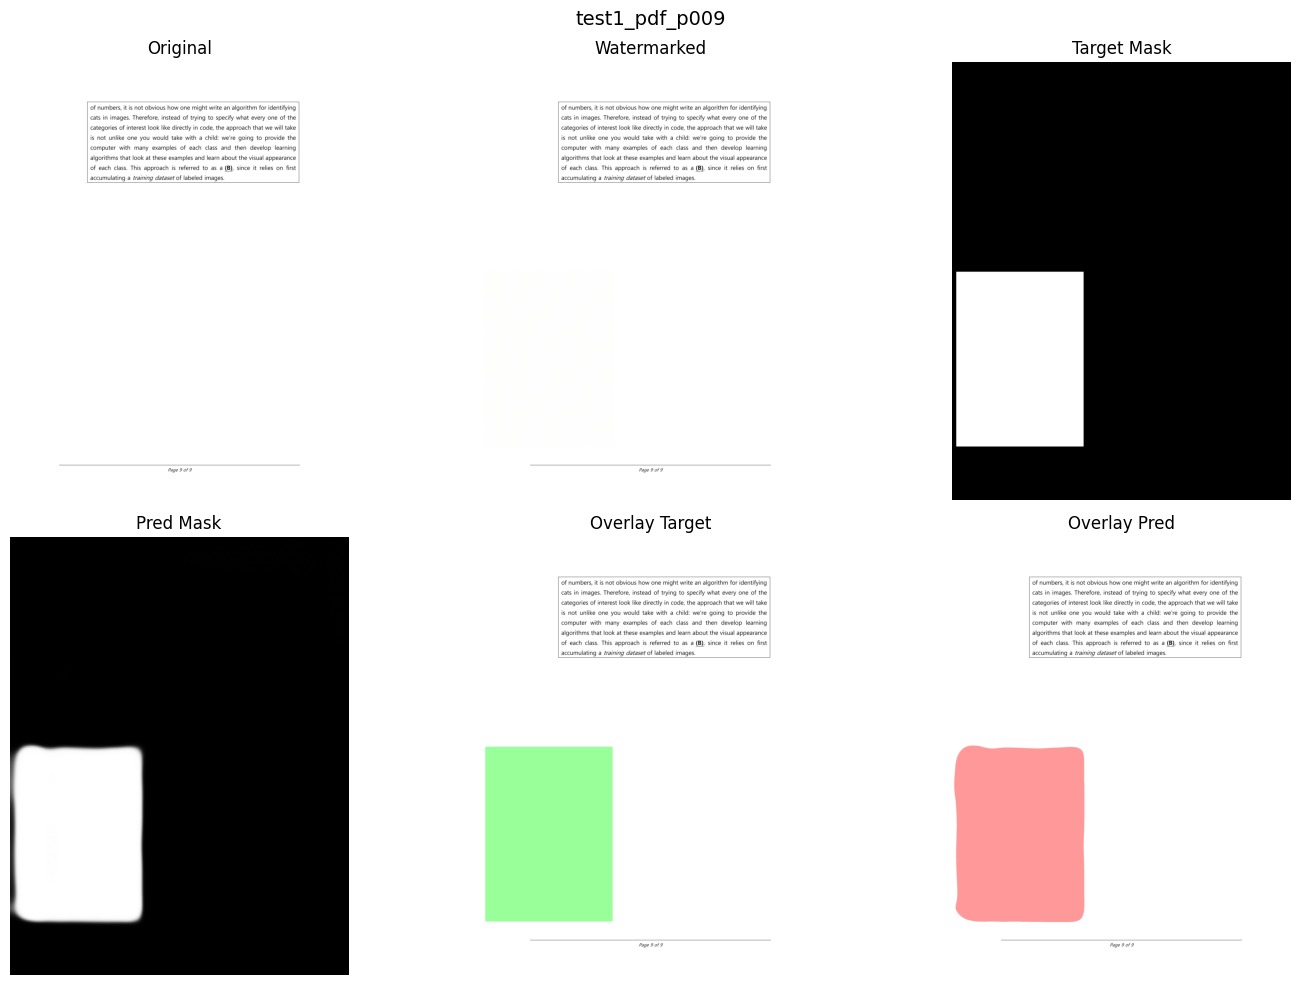

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_DIR = Path("/content/drive/MyDrive/WATSON/wam_outputs/pages")
WM_DIR = Path("/content/drive/MyDrive/WATSON/wam_outputs/watermarked")

MAX_SHOW = None  # 전부 보려면 None, 일부만 보려면 숫자

def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.4):
    img = np.array(image).astype(np.float32)
    m = np.array(mask).astype(np.float32) / 255.0
    m = (m > 0.5).astype(np.float32)
    col = np.array(color, dtype=np.float32)
    out = img.copy()
    out[m > 0] = (1 - alpha) * out[m > 0] + alpha * col
    return Image.fromarray(out.astype(np.uint8))

wm_files = sorted(WM_DIR.glob("*_wm.png"))

count = 0
for wm_path in wm_files:
    base = wm_path.name.replace("_wm.png", "")
    orig_path = IMG_DIR / f"{base}.png"
    target_path = WM_DIR / f"{base}_targetmask.png"
    pred_path = WM_DIR / f"{base}_predmask.png"

    if not (orig_path.exists() and target_path.exists() and pred_path.exists()):
        continue

    orig = Image.open(orig_path).convert("RGB")
    wm = Image.open(wm_path).convert("RGB")
    target = Image.open(target_path).convert("L")
    pred = Image.open(pred_path).convert("L")

    overlay_target = overlay_mask(orig, target, color=(0, 255, 0), alpha=0.4)
    overlay_pred = overlay_mask(orig, pred, color=(255, 0, 0), alpha=0.4)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(base, fontsize=14)

    axes[0, 0].imshow(orig)
    axes[0, 0].set_title("Original")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(wm)
    axes[0, 1].set_title("Watermarked")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(target, cmap="gray")
    axes[0, 2].set_title("Target Mask")
    axes[0, 2].axis("off")

    axes[1, 0].imshow(pred, cmap="gray")
    axes[1, 0].set_title("Pred Mask")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(overlay_target)
    axes[1, 1].set_title("Overlay Target")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(overlay_pred)
    axes[1, 2].set_title("Overlay Pred")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    count += 1
    if MAX_SHOW is not None and count >= MAX_SHOW:
        break